<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Check whether GPU is available

In [499]:
# import torch
# torch.cuda.is_available()

Load data from prepared local csv file

In [500]:
from darts import TimeSeries
import pandas as pd


In [501]:
series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

Prepare train and validation splits

In [502]:
# Split right before a cup base shapes out and a breakout occurs
# As a first iteration, find a model that is able to detect with sufficient confidence high probability breakouts
# that are likely to rally 20% or more in 8 weeks with less than 7% drawdown
train, val = series.split_before(pd.Timestamp('2023-11-03'))


In [503]:
len(train), len(val)

(9835, 30)

In [504]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.06027413]],

       [[0.06242664]],

       [[0.0635035 ]],

       [[0.0618885 ]],

       [[0.06081225]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 1986-03-19
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [505]:
train_df = train.pd_dataframe()


In [506]:
train_df.shape[0] - train_df.dropna().shape[0]

0

In [507]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[377.63999939]],

       [[377.42999268]],

       [[378.60998535]],

       [[382.70001221]],

       [[378.8500061 ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-11-23 2023-11-24 ... 2023-11-29
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [508]:
val_df = val.pd_dataframe()
val_df

component,Close
Date,
2023-11-23,377.639999
2023-11-24,377.429993
2023-11-27,378.609985
2023-11-28,382.700012
2023-11-29,378.850006
2023-11-30,378.910004
2023-12-01,374.510010
2023-12-04,369.140015
2023-12-05,372.519989


In [509]:
val_df.shape[0] - val_df.dropna().shape[0]

0

Plot data splits

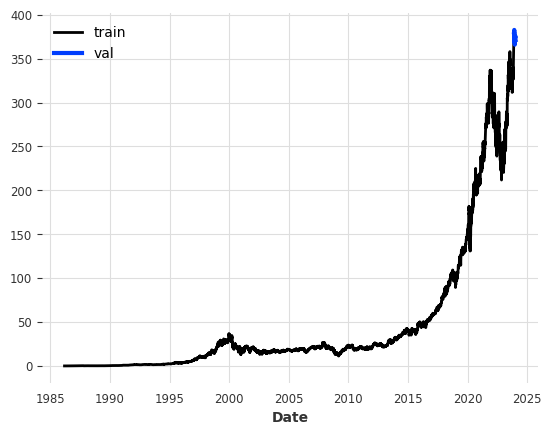

In [510]:
import matplotlib.pyplot as plt
 
train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

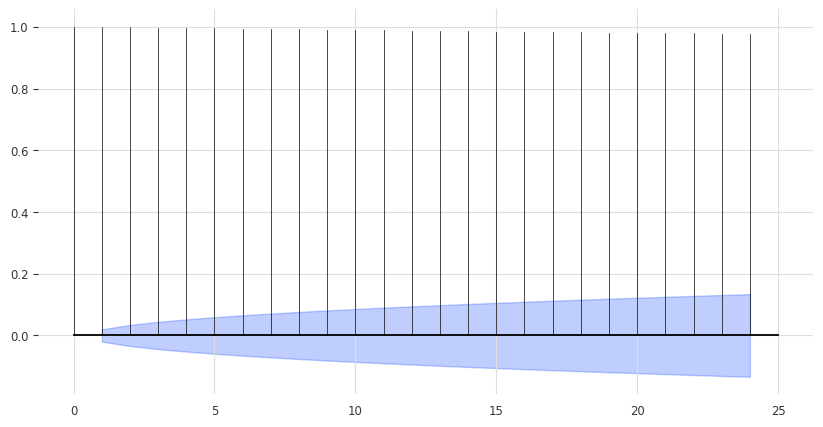

In [511]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train a baseline model to benchmark against

In [512]:
from darts.models import ExponentialSmoothing


baseline_model = ExponentialSmoothing()
baseline_model.fit(train)
prediction = baseline_model.predict(len(val), num_samples=500)

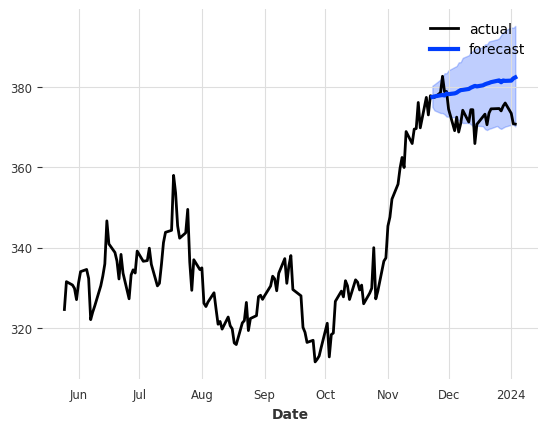

In [513]:
import matplotlib.pyplot as plt
 

actual = series.slice(pd.Timestamp('2023-05-25'), series.end_time())
actual.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

In [514]:
#from darts.models import AutoARIMA
#  
#model_aarima = AutoARIMA()
#model_aarima.fit(train)
#prediction_aarima = model_aarima.predict(len(val))

In [515]:
#import matplotlib.pyplot as plt
# 
#actual.plot(label='actual')
#prediction_aarima.plot(label='forecast', lw=3)
# plt.legend()

Train our current working model

In [516]:
#from darts.dataprocessing.transformers import Scaler
# 
# scaler = Scaler()
#train_air_scaled = scaler.fit_transform(train)
# 
#train_air_scaled.plot()
# 
# encoders = {"datetime_attribute": {"past": ["month", "year"]}} # , "transformer": Scaler()}

In [517]:
train_history = 252 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 100 # model training epochs

In [518]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Proceeding with new model')
  model = TiDEModel(
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      # add_encoders=encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99])
#      model_name=saved_model_name,
#      force_reset=True,
#      save_checkpoints=True,    
  )  



Loading saved model


In [519]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)

In [520]:
supports_multi_ts

True

In [521]:
# train model

model.fit(train, epochs=n_epochs)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | rin              | RINorm           | 2     
4 | encoders         | Sequential       | 81.3 K
5 | decoders         | Sequential       | 1.2 M 
6 | temporal_decoder | _ResidualBlock   | 4.6 K 
7 | lookback_skip    | Linear           | 74.4 K
------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.562     Total estimated model params size (MB)


Epoch 23:  27%|██▋       | 80/299 [00:01<00:03, 62.78it/s, train_loss=1.220] 

In [ ]:
# save model
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, mc_dropout=True, num_samples=500) # len(val))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.29it/s]


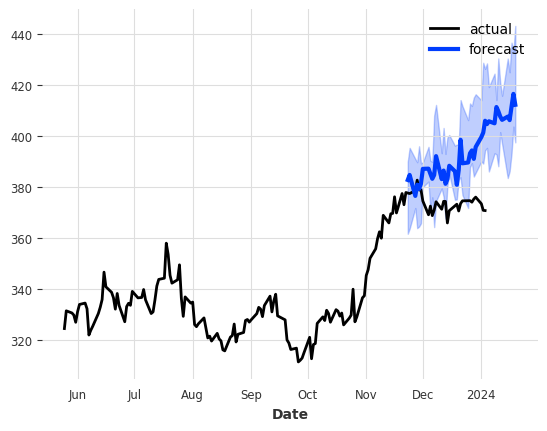

In [ ]:
actual.plot(label='actual')
pred.plot(label='forecast', lw=3)
plt.legend()

Backtest Model


In [ ]:

#models = [ExponentialSmoothing(),
##          NHiTSModel(input_chunk_length=6,
##            output_chunk_length=6),
#          TiDEModel(
#            input_chunk_length=24,
#            output_chunk_length=12,
#            use_reversible_instance_norm=True),
#            ]
#
#backtests = [model.historical_forecasts(series,
#                            start=.5,
#                            forecast_horizon=3)
#             for model in models]

In [ ]:
# from darts.metrics import mape
#
#series.plot(label='data')
#for i, m in enumerate(models):
#    err = mape(backtests[i], series)
#    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))
#
#plt.title('Backtests with 3-months forecast horizon')
#plt.legend()